# MNIST GPU Deep Learning Benchmark with H2O Deep Water
In reference to [Szilard's Benchmark-DL](https://github.com/szilard/benchm-dl)

![MNIST](images/mnist.png)

In [1]:
import sys, os
import os.path
import h2o
from h2o.estimators.deepwater import H2ODeepWaterEstimator
PATH = os.path.expanduser("~/h2o-3/")
#h2o.shutdown(prompt=False)
h2o.init(nthreads=-1)
if not H2ODeepWaterEstimator.available(): exit

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_101"; Java(TM) SE Runtime Environment (build 1.8.0_101-b13); Java HotSpot(TM) 64-Bit Server VM (build 25.101-b13, mixed mode)
  Starting server from /home/arno/h2o-3/build/h2o.jar
  Ice root: /tmp/tmp11lvgx
  JVM stdout: /tmp/tmp11lvgx/h2o_arno_started_from_python.out
  JVM stderr: /tmp/tmp11lvgx/h2o_arno_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,04 secs
H2O cluster version:,3.11.0.99999
H2O cluster version age:,54 minutes
H2O cluster name:,H2O_from_python_arno_nzmn5a
H2O cluster total nodes:,1
H2O cluster free memory:,13.96 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,40
H2O cluster status:,"accepting new members, healthy"
H2O connection url:,http://127.0.0.1:54321
H2O connection proxy:,None


### Hardware check

In [2]:
!nvidia-smi

Mon Oct 24 14:48:00 2016       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 367.44                 Driver Version: 367.44                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 0000:02:00.0      On |                  N/A |
| 33%   45C    P8    11W / 180W |   1520MiB /  8097MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 1080    Off  | 0000:81:00.0      On |                  N/A |
| 32%   43C    P8    11W / 180W |   3273MiB /  8113MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

### Data preparation

In [3]:
train = h2o.import_file(PATH + "bigdata/laptop/mnist/train.csv.gz")
predictors  = list(range(0,784))
resp        = 784

train[predictors] = train[predictors]/255.0
train[resp] = train[resp].asfactor()
nclasses    = train[resp].nlevels()[0]

Parse progress: |█████████████████████████████████████████████████████████| 100%


### Define the model architecture

In [4]:
def cnn(num_classes):
    import mxnet as mx
    data    = mx.symbol.Variable('data')

    conv1   = mx.symbol.Convolution(data=data, kernel=(4,4), num_filter=32)
    relu1   = mx.symbol.Activation(data=conv1, act_type="relu")
    pool1   = mx.symbol.Pooling(data=relu1, pool_type="max", kernel=(2,2), stride=(2,2))

    conv2   = mx.symbol.Convolution(data=pool1, kernel=(3,3), num_filter=16)
    relu2   = mx.symbol.Activation(data=conv2, act_type="relu")
    pool2   = mx.symbol.Pooling(data=relu2, pool_type="max", kernel=(2,2), stride=(2,2))
    drop    = mx.symbol.Dropout(data=pool2, p=0.2)

    flatten = mx.symbol.Flatten(data=drop)
    fc1     = mx.symbol.FullyConnected(data=flatten, num_hidden=128)
    relu3   = mx.symbol.Activation(data=fc1, act_type="relu")

    fc2     = mx.symbol.FullyConnected(data=relu3, num_hidden=64)
    relu4   = mx.symbol.Activation(data=fc2, act_type="relu")

    fc3     = mx.symbol.FullyConnected(data=relu4, num_hidden=num_classes)
    net     = mx.symbol.SoftmaxOutput(data=fc3, name='softmax')
    return net
cnn(nclasses).save("/tmp/cnn.json")

### Train the model

In [5]:
model = H2ODeepWaterEstimator(epochs=10,
                              learning_rate=0.05,
                              learning_rate_annealing=1e-5,
                              momentum_start=0.9,
                              momentum_stable=0.9,
                              mini_batch_size=128,
                              train_samples_per_iteration=0,
                              standardize=False,
                              ignore_const_cols=False,
                              network_definition_file="/tmp/cnn.json",
                              image_shape=[28,28],
                              channels=1,
                              device_id=[0],
                              gpu=True)

model.train(x=predictors,y=resp, training_frame=train)

deepwater Model Build progress: |█████████████████████████████████████████| 100%


### Inspect the model

In [6]:
model.show()

Model Details
H2ODeepWaterEstimator :  Deep Water
Model Key:  DeepWater_model_python_1477345675569_1
Status of Deep Learning Model: user, 261.3 KB, predicting C785, 10-class classification, 600,320 training samples, mini-batch size 128



,input_neurons,rate,momentum
,784,0.0071396,0.9




ModelMetricsMultinomial: deepwater
** Reported on train data. **

MSE: 0.0041367999154
RMSE: 0.064317959509
LogLoss: 0.0160058459629
Mean Per-Class Error: 0.00497543068816
Confusion Matrix: vertical: actual; across: predicted



0,1,2,3,4,5,6,7,8,9,Error,Rate
941.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0010616,1 / 942
0.0,1128.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0044131,"5 / 1,133"
0.0,0.0,1001.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0029880,"3 / 1,004"
0.0,0.0,2.0,1000.0,0.0,1.0,0.0,0.0,1.0,2.0,0.0059642,"6 / 1,006"
0.0,0.0,0.0,0.0,958.0,0.0,1.0,0.0,1.0,0.0,0.0020833,2 / 960
2.0,0.0,0.0,2.0,0.0,887.0,2.0,1.0,5.0,0.0,0.0133482,12 / 899
1.0,0.0,0.0,0.0,1.0,0.0,988.0,0.0,1.0,0.0,0.0030272,3 / 991
0.0,2.0,1.0,0.0,2.0,0.0,0.0,1010.0,0.0,0.0,0.0049261,"5 / 1,015"
0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,992.0,0.0,0.0020121,2 / 994
2.0,0.0,0.0,0.0,2.0,2.0,0.0,2.0,2.0,997.0,0.0099305,"10 / 1,007"


Top-10 Hit Ratios: 


k,hit_ratio
1,0.9950759
2,0.9992965
3,1.0
4,1.0
5,1.0
6,1.0
7,1.0
8,1.0
9,1.0
10,1.0


Scoring History: 


,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_logloss,training_classification_error
,2016-10-24 14:48:10,0.000 sec,None,0.0,0,0.0,nan,nan,nan
,2016-10-24 14:48:18,11.140 sec,8743 obs/sec,1.0005333,1,60032.0,0.1176439,0.0523929,0.0158778
,2016-10-24 14:48:26,17.981 sec,17691 obs/sec,4.0021333,4,240128.0,0.0784880,0.0242536,0.0067330
,2016-10-24 14:48:32,24.713 sec,20832 obs/sec,7.0037333,7,420224.0,0.0717266,0.0199461,0.0061300
,2016-10-24 14:48:38,30.311 sec,21077 obs/sec,9.0048,9,540288.0,0.0647739,0.0167465,0.0049241
,2016-10-24 14:48:40,32.678 sec,21543 obs/sec,10.0053333,10,600320.0,0.0643180,0.0160058,0.0049241


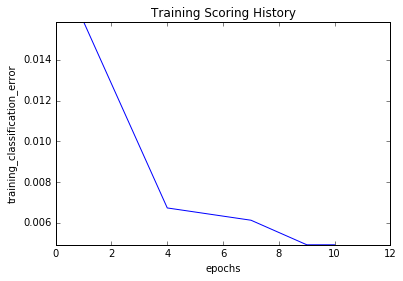

In [7]:
model.plot()

### Let's evaluate the test set performance

In [8]:
test = h2o.import_file(PATH + "bigdata/laptop/mnist/test.csv.gz")
test[predictors] = test[predictors]/255.0
test[resp] = test[resp].asfactor()

print(model.model_performance(test))

Parse progress: |█████████████████████████████████████████████████████████| 100%

ModelMetricsMultinomial: deepwater
** Reported on test data. **

MSE: 0.00686921469757
RMSE: 0.0828807257302
LogLoss: 0.0260866208855
Mean Per-Class Error: 0.00879254678566
Confusion Matrix: vertical: actual; across: predicted



0,1,2,3,4,5,6,7,8,9,Error,Rate
976.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0040816,4 / 980
0.0,1131.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0035242,"4 / 1,135"
1.0,0.0,1025.0,0.0,1.0,0.0,0.0,3.0,2.0,0.0,0.0067829,"7 / 1,032"
0.0,0.0,1.0,1002.0,0.0,4.0,0.0,1.0,2.0,0.0,0.0079208,"8 / 1,010"
0.0,0.0,0.0,0.0,974.0,0.0,2.0,0.0,2.0,4.0,0.0081466,8 / 982
2.0,0.0,0.0,6.0,0.0,881.0,1.0,0.0,1.0,1.0,0.0123318,11 / 892
3.0,2.0,0.0,1.0,1.0,1.0,948.0,0.0,2.0,0.0,0.0104384,10 / 958
0.0,3.0,4.0,0.0,0.0,1.0,0.0,1015.0,1.0,4.0,0.0126459,"13 / 1,028"
1.0,0.0,2.0,1.0,0.0,1.0,0.0,1.0,967.0,1.0,0.0071869,7 / 974
1.0,0.0,1.0,0.0,4.0,3.0,0.0,2.0,4.0,994.0,0.0148662,"15 / 1,009"


Top-10 Hit Ratios: 


k,hit_ratio
1,0.9913
2,0.999
3,0.9996
4,0.9997
5,0.9999
6,0.9999
7,1.0
8,1.0
9,1.0
10,1.0


In [9]:
h2o.download_all_logs("/tmp/")

Writing H2O logs to /tmp/h2ologs_20161024_024844.zip


u'/tmp/h2ologs_20161024_024844.zip'